**References: I used ChatGPT for reference**

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys

# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

# Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp "/content/drive/My Drive/lfw.zip" "/content/"

In [4]:
import zipfile
with zipfile.ZipFile("/content/lfw.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")
path = 'lfw'

In [5]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [6]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU not available. Using CPU.")

MPS device not found.
Using GPU: Tesla T4


torch.Size([250, 250, 3])


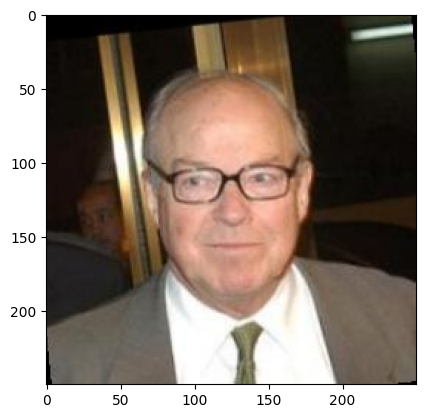

In [7]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

Variational Autoencoders (VAEs) and traditional Autoencoders (AEs) are both types of neural network architectures used for unsupervised learning tasks, particularly in the domain of data compression and generation. While they share some similarities, there are distinct differences in their applications, architecture, and loss functions.

### Applications

**AutoEncoders (AEs):**
- **Dimensionality Reduction**: AEs are often used for reducing the dimensionality of data, similar to PCA, but in a nonlinear fashion.
- **Data Denoising**: They can effectively denoise data by learning to ignore the "noise" and reconstruct the clean data.
- **Feature Learning**: AEs can learn meaningful, often hierarchical, features in an unsupervised manner, which can be useful for other downstream tasks.

**Variational AutoEncoders (VAEs):**
- **Data Generation**: VAEs are powerful generative models. They can generate new data samples that are similar to the input data, making them useful in fields like image generation, style transfer, etc.
- **Semi-Supervised Learning**: Due to their probabilistic nature, VAEs can be adapted for semi-supervised learning scenarios.
- **Latent Space Exploration and Interpolation**: VAEs provide a structured latent space that enables smooth interpolation and exploration, which can be used in creative applications like morphing one image into another.

### Architecture

**AutoEncoders (AEs):**
- **Structure**: Comprise an encoder and a decoder. The encoder compresses the input into a lower-dimensional latent space, and the decoder reconstructs the input from this latent representation.
- **Deterministic**: The mapping from input space to latent space and back is deterministic.

**Variational AutoEncoders (VAEs):**
- **Probabilistic Nature**: Unlike AEs, VAEs are probabilistic. The encoder in a VAE maps inputs to a distribution over the latent space.
- **Encoder Output**: The encoder of a VAE produces two outputs for each input: the mean and variance (or log variance) of a Gaussian distribution representing the latent space.
- **Reparameterization Trick**: VAEs use this trick to sample from the latent space distribution, allowing backpropagation through stochastic nodes.

### Loss Function

**AutoEncoders (AEs):**
- **Typical Loss**: The loss function in a standard AE is often a simple reconstruction loss, such as Mean Squared Error (MSE) or Binary Cross-Entropy, measuring the difference between the input and its reconstruction.

**Variational AutoEncoders (VAEs):**
- **Reconstruction Loss**: Like AEs, VAEs have a reconstruction loss component. However, it’s often interpreted as a probabilistic likelihood (e.g., MSE under a Gaussian assumption or Binary Cross-Entropy under a Bernoulli assumption).
- **KL Divergence**: The second component of the VAE loss function is the Kullback-Leibler (KL) divergence between the encoded distribution and a prior distribution (usually a standard normal distribution). This divergence measures how much the learned distribution deviates from the prior and ensures that the latent space has good properties for generative tasks.


In essence, while both AEs and VAEs encode inputs into a latent space and then decode from it, VAEs introduce a probabilistic twist to this process. This twist not only allows for the generation of new, plausible data samples but also imposes a structure on the latent space, making it suitable for various generative applications. The key distinction lies in the VAE's use of a probabilistic latent space and a loss function that balances reconstruction quality with regularization of the latent space.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim

        # Encoder
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # Output: [32, 125, 125]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # Output: [64, 63, 63]
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # Output: [128, 32, 32]
            nn.ReLU(),
        )

        self.fc_mu = nn.Linear(128 * 32 * 32, latent_dim)
        self.fc_log_var = nn.Linear(128 * 32 * 32, latent_dim)

        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, 128 * 32 * 32)
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Output: [64, 63, 63]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # Output: [32, 125, 125]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),    # Output: [3, 250, 250]
            nn.ReLU(),
        )

        # Adaptive Pooling to match the output size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((250, 250))

    def encoder(self, x):
        x = self.encoder_conv(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decoder(self, x):
        x = self.decoder_fc(x)
        x = x.view(x.size(0), 128, 32, 32)
        x = self.decoder_conv(x)
        x = self.adaptive_pool(x)  # Ensuring the output size matches the input
        return x

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decoder(z)
        return x_recon, mu, log_var


The explanation of the above code is as follows

### Variational Autoencoder (VAE) Class Overview

The `VAE` class defined in the provided code inherits from PyTorch's `nn.Module` and represents a Variational Autoencoder. A VAE is a type of generative model that learns to encode inputs to a latent probabilistic representation and then decode from this space to reconstruct the input. The key components of this class are as follows:

#### 1. Constructor `__init__(self, latent_dim)`:
- **Latent Dimension (`latent_dim`)**: This parameter defines the size of the latent space. In a VAE, the latent space is typically smaller than the input dimension, leading to data compression.
- **Encoder Network**:
  - **Convolutional Layers (`encoder_conv`)**: These layers progressively downsample the input image, extracting features and reducing its spatial dimensions.
  - **Linear Layers (`fc_mu` and `fc_log_var`)**: These layers map the flattened output of the convolutional layers to two different vectors: the mean (`mu`) and the log-variance (`log_var`) of the latent space distribution.
- **Decoder Network**:
  - **Linear Layer (`decoder_fc`)**: It maps the latent representation back to the spatial dimensionality required for convolutional transpose layers.
  - **Convolutional Transpose Layers (`decoder_conv`)**: These layers upsample the feature maps back to the original input dimensions, reconstructing the input image from the latent representation.

#### 2. Encoder Function `encoder(self, x)`:
- It applies the encoder convolutional network to the input `x`, flattens the output, and then passes it through two separate linear layers to produce the mean and log variance of the latent distribution.

#### 3. Reparameterization Function `reparameterize(self, mu, log_var)`:
- This function takes the mean and log variance and applies the "reparameterization trick" to sample from the latent distribution. This trick is crucial for enabling gradient backpropagation through stochastic nodes.

#### 4. Decoder Function `decoder(self, x)`:
- It takes a latent vector, reshapes and up-samples it through a linear layer followed by a series of transposed convolutional layers, reconstructing the image from the latent representation.

#### 5. Forward Pass `forward(self, x)`:
- In the forward pass, the input `x` is first encoded to `mu` and `log_var`, then a latent vector `z` is sampled using `reparameterize`, and finally, `z` is decoded back to the reconstructed input.

### VAE vs. Autoencoder

Compared to a standard Autoencoder, a VAE introduces a probabilistic twist to both the encoding and decoding processes:

- **Probabilistic Encoding**: Instead of encoding an input to a fixed point, a VAE encodes it to a distribution in the latent space. This is achieved through the `encoder` function that produces `mu` and `log_var`.
- **Reparameterization Trick**: The `reparameterize` function allows the VAE to sample from the latent distribution while still enabling gradient-based optimization, a key aspect distinguishing VAEs from traditional autoencoders.
- **Probabilistic Decoding**: The decoder in a VAE learns to reconstruct the input from the probabilistically sampled latent representation.

### Conclusion

The provided VAE class effectively demonstrates these VAE-specific features. By contrast, a standard autoencoder would typically have deterministic mappings between the input, latent space, and reconstruction, without the probabilistic interpretation of the latent space and the associated reparameterization trick.

# Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.

In [9]:
model = VAE(latent_dim=512).to(device)

In [10]:
# Prepare the input image for the model
transformed_image = x.permute(2, 0, 1).unsqueeze(0).to(device)

# Conducting a forward pass through the VAE
reconstructed_image, mean, log_variance = model(transformed_image)

# Displaying the shapes of the outputs from the encoder
print("Shapes from Encoder - Mean:", mean.shape, "; Log Variance:", log_variance.shape)

# Generating a sample from the latent space
latent_sample = model.reparameterize(mean, log_variance)

# Decoding the sample to create a new image
newly_generated_image = model.decoder(latent_sample)

# Displaying the shape of the image generated by the decoder
print("Shape of Image from Decoder:", newly_generated_image.shape)


Shapes from Encoder - Mean: torch.Size([1, 20]) ; Log Variance: torch.Size([1, 20])
Shape of Image from Decoder: torch.Size([1, 3, 250, 250])


**The above code demonstrates the creation and use of a Variational Autoencoder (VAE) for encoding an ima
ge into a latent space and then generating new images from this latent space.**

### Creating an Instance of the VAE
The VAE is instantiated with a specified latent dimension (`latent_dim=20`). This dimensionality defines the size of the latent space, which is a critical hyperparameter in VAEs as it determines the capacity of the model to encode various features of the input data.

```python
model = VAE(latent_dim=20).to(device)
```

### Preparing and Processing the Input Image
An input image `x` is transformed to match the input format expected by PyTorch models (`[channels, height, width]`) and is then added a batch dimension using `unsqueeze(0)`. This transformation is crucial for the model to correctly process the image.

```python
transformed_image = x.permute(2, 0, 1).unsqueeze(0).to(device)
```

### Forward Pass Through the VAE
The transformed image is passed through the VAE. The model's encoder first maps the image to a distribution in the latent space, represented by `mean` and `log_variance`. These outputs provide the parameters of the Gaussian distribution from which we'll sample our latent vector.

```python
reconstructed_image, mean, log_variance = model(transformed_image)
```

Printing the shapes of `mean` and `log_variance` confirms the structure of this latent space representation. It's important that both have the shape `[batch_size, latent_dim]`, matching the intended design of the VAE.

### Generating New Samples from the Latent Space
The latent space is where the VAE's generative capabilities come into play. Using the `reparameterize` function, a sample (`latent_sample`) is drawn from the distribution defined by `mean` and `log_variance`. This process, known as the reparameterization trick, enables the VAE to backpropagate through random sampling, a key aspect of its training process.

```python
latent_sample = model.reparameterize(mean, log_variance)
```

### Decoding to Create New Images
The sampled latent vector is then passed through the decoder part of the VAE to generate a new image. This step essentially reconstructs an image from the sampled point in the latent space.

```python
newly_generated_image = model.decoder(latent_sample)
```

The shape of this newly generated image is printed to verify that the decoding process reconstructs images of the correct dimensions. The expected shape should be `[batch_size, channels, height, width]`, which should match the original input image's dimensions.

### Summary
This code effectively demonstrates the core functionality of a VAE: encoding an input to a probabilistic latent space and then decoding from this space to either reconstruct the input or generate new data. The encoder's output provides a probabilistic understanding of the input in the latent space, and the decoder leverages this representation to generate or reconstruct images. The ability to sample and decode from the latent space is what gives VAEs their power as generative models.

#  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


* create an optimizer for training

In [11]:
total_params_vae = sum(p.numel() for p in model.parameters())
print(f"Total Number of Parameters in VAE: {total_params_vae}")

Total Number of Parameters in VAE: 8254155


In [12]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
# Resize the input image to match the model's expected input dimensions
resized_input_img = F.interpolate(transformed_image, size=(250, 250), mode='bilinear', align_corners=False).to(device)

# Compute the Reconstruction Loss (MSE Loss)
mse_recon_loss = F.mse_loss(reconstructed_image, resized_input_img, reduction='sum')

# Compute the KL Divergence Loss
kl_div_loss = -0.5 * torch.sum(1 + log_variance - mean.pow(2) - torch.exp(log_variance))

# Calculate the Total Loss by combining Reconstruction and KL Divergence Losses
total_vae_loss = mse_recon_loss + kl_div_loss

**The explanation of the above code is as follows:**
### Total Number of Parameters in the VAE Model

The total number of parameters in the Variational Autoencoder (VAE) model is a measure of its complexity. By summing the number of elements in each parameter tensor, we can get an idea of the model's capacity to learn from data:

```python
total_params_vae = sum(p.numel() for p in model.parameters())
print(f"Total Number of Parameters in VAE: {total_params_vae}")
```

This value is important for understanding the model's potential for overfitting or underfitting and can impact training time and memory requirements.

### Loss Function for VAE

The loss function for a VAE is critical for its training and has two distinct components:

#### 1. Reconstruction Loss

The reconstruction loss measures how well the VAE can reconstruct the input data from the latent space. This part of the loss ensures that the model learns to encode useful information about the input data in the latent space. For image data, Mean Squared Error (MSE) is a common choice:

```python
mse_recon_loss = F.mse_loss(reconstructed_image, resized_input_img, reduction='sum')
```

- **MSE Loss**: It calculates the average squared difference between the original (resized) image and the reconstructed image from the VAE. The goal is to minimize this difference, encouraging the decoder to produce outputs as close as possible to the original inputs.

#### 2. KL Divergence Loss

The Kullback-Leibler (KL) Divergence loss is unique to VAEs and is essential for learning a well-structured latent space:

```python
kl_div_loss = -0.5 * torch.sum(1 + log_variance - mean.pow(2) - torch.exp(log_variance))
```

- **KL Divergence**: This term measures how much the distribution of the encoded latent variables (defined by `mean` and `log_variance`) deviates from a prior distribution, typically a standard normal distribution. By minimizing the KL divergence, the VAE is encouraged to keep its latent variable distributions close to the prior. This regularization aspect prevents the model from encoding the input data too specifically (overfitting), thus ensuring that the latent space has good properties for generative tasks.

### Total Loss Calculation

The total loss for training the VAE is the sum of the reconstruction loss and the KL divergence loss:

```python
total_vae_loss = mse_recon_loss + kl_div_loss
```

- **Combining Losses**: This combination ensures that the VAE learns to both accurately reconstruct the input data and maintain a meaningful and well-structured latent space. The balance between these two aspects is crucial: focusing too much on reconstruction can lead to a less meaningful latent space, while overemphasizing the KL divergence can lead to poor reconstruction quality.

In summary, the loss function for a VAE serves a dual purpose: guiding the model to accurately reconstruct input data while also regularizing the latent space to have useful properties for generative modeling. This dual nature is what makes VAEs particularly effective and versatile as generative models.

#  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [14]:
import matplotlib.pyplot as plt

# Initialize lists to store the average losses
avg_mse_recon_losses = []
avg_kl_div_losses = []
avg_total_losses = []

num_epochs = 10

for epoch in range(num_epochs):
    sum_mse_recon_loss = 0.0
    sum_kl_div_loss = 0.0
    sum_total_vae_loss = 0.0

    for imgs, _ in dataloader:
        # Resizing the images to match the expected input size of the VAE
        resized_imgs = F.interpolate(imgs, size=(250, 250), mode='bilinear', align_corners=False).to(device)

        # Conducting a forward pass through the VAE
        vae_output, mean, log_variance = model(resized_imgs)

        # Computing the Mean Squared Error (MSE) Reconstruction Loss
        mse_recon_loss = F.mse_loss(vae_output, resized_imgs, reduction='sum')

        # Calculating the KL Divergence Loss
        kl_div_loss = -0.5 * torch.sum(1 + log_variance - mean.pow(2) - torch.exp(log_variance))

        # Summing up to get the Total Loss for the VAE
        total_vae_loss = mse_recon_loss + kl_div_loss

        # Executing the backward pass and optimization step
        optim.zero_grad()
        total_vae_loss.backward()
        optim.step()

        # Accumulating the losses for the current batch
        sum_mse_recon_loss += mse_recon_loss.item()
        sum_kl_div_loss += kl_div_loss.item()
        sum_total_vae_loss += total_vae_loss.item()

    # Calculating average losses for the epoch
    avg_mse_recon_loss = sum_mse_recon_loss / len(dataloader)
    avg_kl_div_loss = sum_kl_div_loss / len(dataloader)
    avg_total_vae_loss = sum_total_vae_loss / len(dataloader)

    # Storing the average losses for plotting
    avg_mse_recon_losses.append(avg_mse_recon_loss)
    avg_kl_div_losses.append(avg_kl_div_loss)
    avg_total_losses.append(avg_total_vae_loss)

    # Printing the average losses for the current epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Avg MSE Reconstruction Loss: {avg_mse_recon_loss:.4f}, Avg KL Divergence Loss: {avg_kl_div_loss:.4f}, Avg Total Loss: {avg_total_vae_loss:.7f}')


Epoch [1/10], Avg MSE Reconstruction Loss: 2008966.1289, Avg KL Divergence Loss: 33431.2932, Avg Total Loss: 2042397.4216863
Epoch [2/10], Avg MSE Reconstruction Loss: 223053.1158, Avg KL Divergence Loss: 2511.4267, Avg Total Loss: 225564.5423838
Epoch [3/10], Avg MSE Reconstruction Loss: 180997.8558, Avg KL Divergence Loss: 2352.4894, Avg Total Loss: 183350.3456371
Epoch [4/10], Avg MSE Reconstruction Loss: 171001.2313, Avg KL Divergence Loss: 2251.0671, Avg Total Loss: 173252.2984601
Epoch [5/10], Avg MSE Reconstruction Loss: 167653.8429, Avg KL Divergence Loss: 2211.8503, Avg Total Loss: 169865.6933877
Epoch [6/10], Avg MSE Reconstruction Loss: 165823.1630, Avg KL Divergence Loss: 2200.4087, Avg Total Loss: 168023.5716335
Epoch [7/10], Avg MSE Reconstruction Loss: 164293.0389, Avg KL Divergence Loss: 2204.3656, Avg Total Loss: 166497.4044195
Epoch [8/10], Avg MSE Reconstruction Loss: 162864.0157, Avg KL Divergence Loss: 2186.4577, Avg Total Loss: 165050.4729959
Epoch [9/10], Avg MSE

**The provided script outlines a training loop for a Variational Autoencoder (VAE) model. This training loop is crucial for fine-tuning the model parameters to effectively encode and decode images.**

### Training Loop Breakdown

1. **Epoch Iteration**: The loop iterates over a predefined number of epochs (`num_epochs`). Each epoch represents a complete pass through the entire dataset.

2. **Loss Accumulation**: Within each epoch, the script initializes variables to accumulate the Mean Squared Error (MSE) reconstruction loss, Kullback-Leibler (KL) divergence loss, and the total loss across all batches.

3. **Batch Processing**:
    - **Image Resizing**: Each batch of images (`imgs`) from the `dataloader` is resized to match the VAE's expected input dimensions. This resizing is necessary if the VAE is designed for a specific input size.
    - **Forward Pass**: The resized images are passed through the VAE. The model outputs the reconstructed images (`vae_output`), the mean (`mean`), and the log variance (`log_variance`) of the latent space distribution.

4. **Loss Computation**:
    - **Reconstruction Loss**: The MSE loss computes the average squared difference between the original and reconstructed images. This loss encourages the VAE to accurately reconstruct the input images.
    - **KL Divergence Loss**: This loss measures the divergence between the learned latent distribution and a standard normal distribution. It helps regularize the latent space.

5. **Backpropagation and Optimization**:
    - After calculating the total loss (`total_vae_loss`), the script performs backpropagation (`total_vae_loss.backward()`) and updates the model weights using an optimizer.

6. **Loss Reporting**: At the end of each epoch, the script calculates and prints the average reconstruction loss, KL divergence loss, and total loss. This reporting is vital for monitoring the training progress.

### Troubleshooting Non-Decreasing Loss

If the loss isn't decreasing as expected, consider the following steps:

- **Learning Rate Adjustment**: The learning rate might be too high or too low. Try adjusting it to see if it improves the loss reduction.

- **Model Architecture Review**: Verify if the model’s architecture is suitable for the complexity of the data. Sometimes, adding or reducing layers can help.

- **Overfitting/Underfitting Check**: If the model is overfitting or underfitting, consider adding dropout layers or batch normalization, or adjust the model complexity.

- **Data Preprocessing**: Ensure that the data preprocessing steps (like normalization) are appropriate for your model and data.

- **Initialization**: Experiment with different weight initialization methods. Poor initialization can impede training.

- **Batch Size**: Sometimes, changing the batch size can impact the learning dynamics.

- **Regularization Tuning**: Adjust the balance between the reconstruction loss and the KL divergence. Sometimes, adding a coefficient to balance these terms can be beneficial.

- **Shuffle Data**: Make sure the data is shuffled properly to avoid biased training due to ordering.

By systematically addressing each of these areas, you can troubleshoot and improve the training process of your VAE. Remember, training a VAE can be complex due to its probabilistic nature, and it may require several iterations of tuning and experimentation to achieve optimal results.

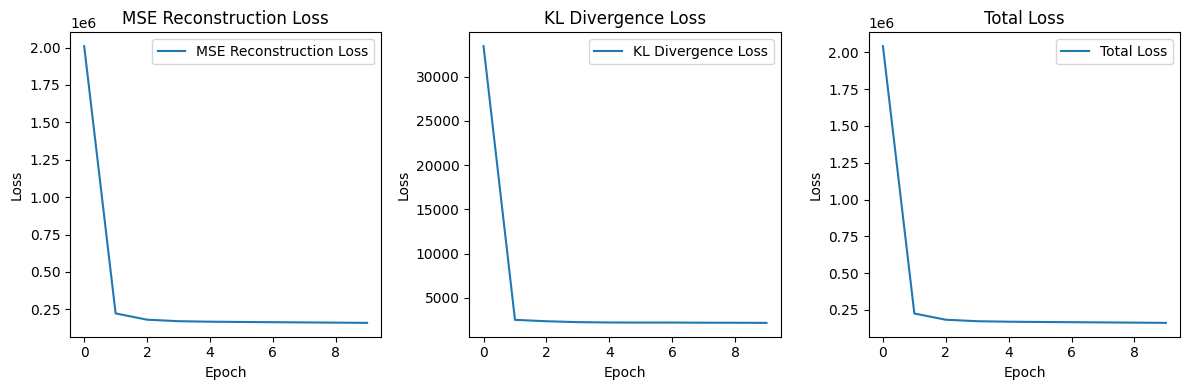

In [15]:
# Plotting the average losses
plt.figure(figsize=(12, 4))

# Plotting the average MSE Reconstruction Loss
plt.subplot(1, 3, 1)
plt.plot(avg_mse_recon_losses, label='MSE Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MSE Reconstruction Loss')
plt.legend()

# Plotting the average KL Divergence Loss
plt.subplot(1, 3, 2)
plt.plot(avg_kl_div_losses, label='KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('KL Divergence Loss')
plt.legend()

# Plotting the average Total Loss
plt.subplot(1, 3, 3)
plt.plot(avg_total_losses, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Total Loss')
plt.legend()

plt.tight_layout()
plt.show()

**The above code is designed to visually represent the training progress of a Variational Autoencoder (VAE) by plotting the average losses per epoch. It uses Matplotlib, a popular Python library for data visualization, to create a series of line plots.**

### Overall Plot Configuration
```python
plt.figure(figsize=(12, 4))
```
- `plt.figure` creates a new figure for plotting. `figsize=(12, 4)` sets the dimensions of the figure to 12 inches in width and 4 inches in height, providing ample space to display the plots clearly.

### Plotting the Average MSE Reconstruction Loss
```python
plt.subplot(1, 3, 1)
plt.plot(avg_mse_recon_losses, label='MSE Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MSE Reconstruction Loss')
plt.legend()
```
- `plt.subplot(1, 3, 1)`: This line configures the subplot layout. `1, 3, 1` means there is 1 row, 3 columns, and this is the first plot.
- `plt.plot(avg_mse_recon_losses, label='MSE Reconstruction Loss')`: Plots the average Mean Squared Error (MSE) Reconstruction Loss per epoch. This loss measures how well the VAE reconstructs the input data.
- `plt.xlabel('Epoch')`, `plt.ylabel('Loss')`, and `plt.title('MSE Reconstruction Loss')`: These lines add labels to the x-axis, y-axis, and a title to the plot.
- `plt.legend()`: Adds a legend to the plot, making it clear that the line represents the MSE Reconstruction Loss.

### Plotting the Average KL Divergence Loss
```python
plt.subplot(1, 3, 2)
plt.plot(avg_kl_div_losses, label='KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('KL Divergence Loss')
plt.legend()
```
- Similar to the first plot, this plots the average Kullback-Leibler (KL) Divergence Loss per epoch in the second subplot. The KL Divergence Loss ensures the distribution of the encoded latent variables is close to the prior distribution, typically a standard normal distribution.

### Plotting the Average Total Loss
```python
plt.subplot(1, 3, 3)
plt.plot(avg_total_losses, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Total Loss')
plt.legend()
```
- This is the third subplot, showing the average Total Loss per epoch, which is the sum of the MSE Reconstruction Loss and the KL Divergence Loss.

### Finalizing and Displaying the Plot
```python
plt.tight_layout()
plt.show()
```
- `plt.tight_layout()` automatically adjusts the subplot parameters for a well-structured layout.
- `plt.show()` displays the final figure with all the subplots.

### Conclusion
This visualization is crucial for assessing the training performance of the VAE. Ideally, both the reconstruction loss and the KL divergence loss should decrease over time, indicating effective learning. The line plots provide a clear, epoch-wise progression of these losses, helping to identify trends and potential issues in the training process.

#  Step 7

Take a random image from the dataset and plot it together with new samples generated.

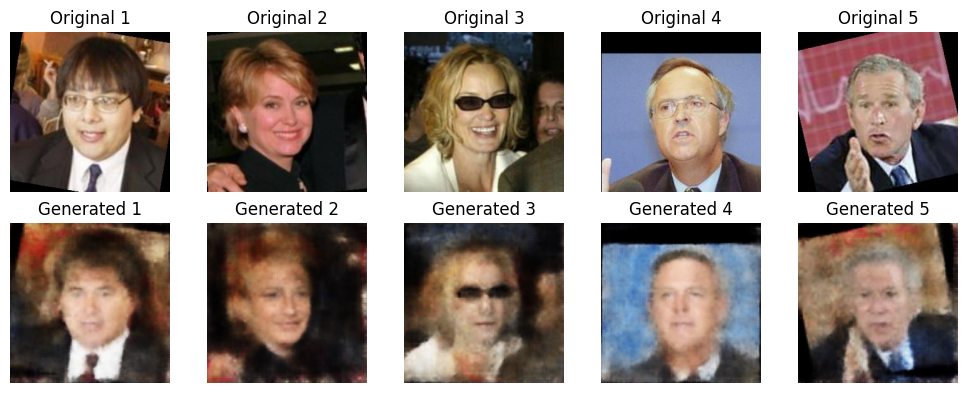

In [31]:
import matplotlib.pyplot as plt
import random

# Activate evaluation mode of the model
model.eval()

# Define the number of original images and generated images per original
num_originals = 5
num_generated_per_original = 1

# Set up the figure for plotting
plt.figure(figsize=(num_originals * 2, 4))

for i in range(num_originals):
    # Randomly select an image from the dataset
    chosen_index = random.randint(0, len(dataloader.dataset) - 1)
    selected_image, _ = dataloader.dataset[chosen_index]

    # Transfer the selected image to the appropriate device
    selected_image = selected_image.unsqueeze(0).to(device)

    # Encode the selected image without updating model parameters
    with torch.no_grad():
        latent_mu, latent_log_var = model.encoder(selected_image)

    # Sampling from the latent space to obtain an encoded representation
    encoded_sample = model.reparameterize(latent_mu, latent_log_var)

    # Display the original image
    plt.subplot(2, num_originals, i + 1)
    plt.imshow(selected_image.squeeze().cpu().numpy().transpose(1, 2, 0))
    plt.title(f"Original {i+1}")
    plt.axis('off')

    # Generate and display new images from the latent space
    for j in range(num_generated_per_original):
        # Decode the sample to generate new images
        with torch.no_grad():
            new_images = model.decoder(encoded_sample)

        # Transfer the new images back to CPU for visualization
        new_images_cpu = new_images.cpu()

        # Display the generated image
        plt.subplot(2, num_originals, num_originals + i + 1)
        plt.imshow(new_images_cpu.squeeze().numpy().transpose(1, 2, 0))
        plt.title(f"Generated {i+1}")
        plt.axis('off')

# Display the complete plot
plt.tight_layout()
plt.show()

**This step involves visualizing the capabilities of the trained Variational Autoencoder (VAE). This step includes taking 5 random images from your dataset and plotting it alongside new images generated by the VAE.**

### Visualization Process

1. **Model Evaluation Mode**:
   - `model.eval()` switches the model to evaluation mode. This is important because it tells the model to behave in inference mode, not training mode. Layers like dropout or batch normalization will work differently during evaluation.

2. **Random Image Selection**:
   - A random image is selected from the dataset. This demonstrates the model's capability to handle arbitrary inputs from the dataset.

3. **Image Processing**:
   - The selected image is processed (added a batch dimension and transferred to the device) to match the input requirements of the model.

4. **Encoding the Image**:
   - The image is passed through the encoder part of the VAE to obtain the mean (`latent_mu`) and log variance (`latent_log_var`) of its latent representation. This step effectively compresses the image into a lower-dimensional, probabilistic latent space.

5. **Latent Space Sampling**:
   - `model.reparameterize(latent_mu, latent_log_var)` samples a point from the latent space distribution inferred from the selected image. This process is crucial for generating new data points that are variations of the original image.

6. **Generating New Images**:
   - The sampled latent vector is then decoded back into image space. This is where the generative aspect of the VAE comes into play, as it creates new images that are variations based on the original image's latent representation.

7. **Visualization**:
   - The original and generated images are displayed side-by-side for comparison. This visual comparison helps to illustrate the effectiveness of the VAE in capturing and varying the key characteristics of the input image.

### Significance

- **Understanding Model Performance**: By visually comparing the original and generated images, you can qualitatively assess how well the VAE has learned to encode and decode images, and how effectively it captures the variability in the data.
  
- **Latent Space Exploration**: This exercise also showcases the ability of the VAE to explore the latent space and generate plausible variations of the input data, highlighting its potential use in applications like image augmentation, art generation, etc.

- **Model Robustness**: By choosing images randomly, you can test the robustness of the model across different data points in your dataset.

This step is crucial in demonstrating the practical capabilities of VAE. It not only serves as a validation of your model’s performance but also provides insight into the characteristics of the learned latent space.